In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import strategy_simulator as ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and process data

In [19]:
# price_data = pd.read_csv(os.path.join('..', 'data', 'SOL', 'SOLUSD.csv'), names = ['time', 'price', 'volume'])
# price_data['time'] = pd.to_datetime(price_data['time'], unit = 's')
# price_data.set_index('time', inplace = True)
# price_data.dropna(inplace = True)
price_data = pd.read_pickle(os.path.join('..', 'data', 'SOL', "SOLUSD_price-volume_minute.pickle"))
price_data

,price,volume
time,,
2021-06-17 15:32:00,40.230000,15.453348
2021-06-17 15:33:00,40.230000,2.707595
2021-06-17 15:34:00,40.230000,2.707595
2021-06-17 15:35:00,40.240000,10.841105
2021-06-17 15:36:00,40.240000,0.200000
...,...,...
2022-03-31 23:55:00,122.493333,6.510785
2022-03-31 23:56:00,122.604444,14.756561
2022-03-31 23:57:00,122.677143,6.616683


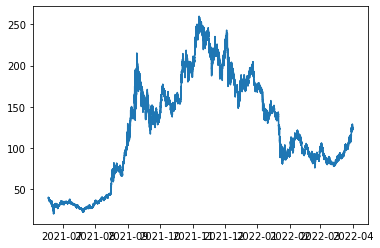

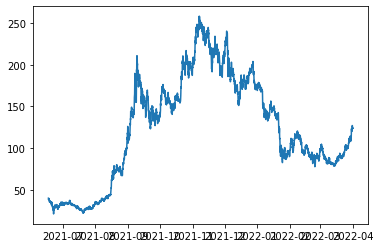

In [23]:
plt.plot(price_data['price'])
plt.show()
price_data_hourly = price_data.resample('1H').mean().fillna(method='ffill')
plt.plot(price_data_hourly['price'])
plt.show()

In [25]:
x_new = [price_data_hourly['price'].iloc[0]]
for i in range(len(price_data_hourly) - 1):
    price = price_data_hourly['price'].iloc[i+1]
    x_new.append(ss.exponential_moving_average(price, x_new[-1], 0.05))

price_data_hourly['mean'] = x_new
fig = px.line(price_data_hourly[-1000:], y=["price", 'mean'])
fig.show()



### Test strategies using trade simulator

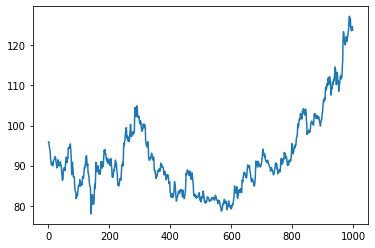

Reserve: 100
Invested: 129.20098602100558
Total: 229.20098602100558
Baseline: 229.20098602100515




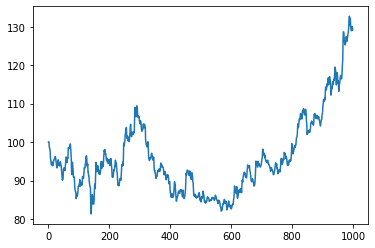

Reserve: 0
Invested: 263.6249509369667
Total: 263.6249509369667
Baseline: 229.20098602100515




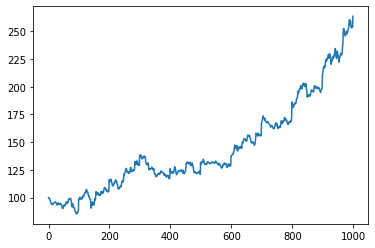

Reserve: 0.0
Invested: 269.1740402062231
Total: 269.1740402062231
Baseline: 229.20098602100515




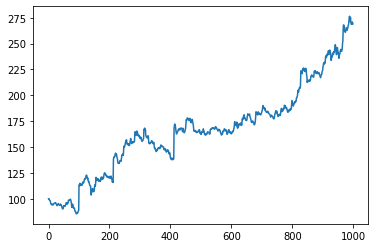

Reserve: 217.0900750373517
Invested: 12.031389928670682
Total: 229.1214649660224
Baseline: 229.20098602100515




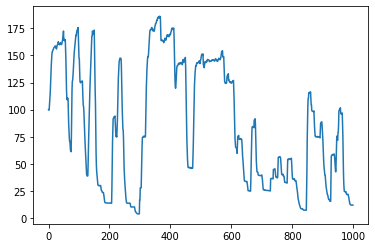

In [26]:
last_n = 1000 #len(resampled)


s1 = ss.hodl()
s2 = ss.DCA(period = last_n/10, amount = 10)
s3 = ss.randomDCA(period = last_n/10, amount = 10)
s4 = ss.percentage_from_mean(avg_start = price_data_hourly['price'].iloc[-last_n])

plt.plot(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
plt.show()

strategies = [s1, s2, s3, s4]

for s in strategies:
    sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
    sim.run(s)
    plt.plot(sim.invested_ot)
    plt.show()

Reserve: 129.56132880300876
Invested: 100.0
Total: 229.56132880300876
Baseline: 229.20098602100515




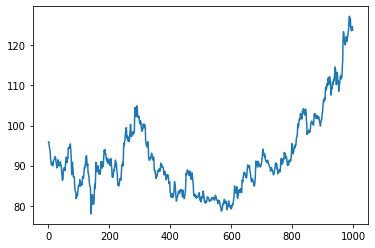

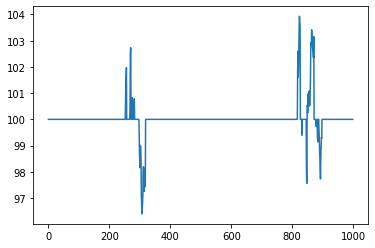

In [27]:
last_n = 1000 #len(resampled)
strategy = ss.maintain_investment()
sim = sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
sim.run(strategy)
    

plt.plot(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
plt.show()
plt.plot(sim.invested_ot)
# plt.plot(sim.reserves)
plt.show()

In [28]:
last_n = len(price_data_hourly)
strategy = ss.slow_fast_avg(avg_start = price_data_hourly['price'].iloc[-last_n], beta_slow = 0.1, beta_fast = 0.3, trade_amount = 1000)
sim = sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
sim.run(strategy)
    

# plt.plot(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
# plt.plot(strategy.avg_fast_ot)
# plt.plot(strategy.avg_slow_ot)
# plt.show()
# plt.plot(sim.invested_ot)
# # plt.plot(sim.reserves)
# plt.show()

temp = price_data_hourly[-last_n:]
temp['fast_avg'] = strategy.avg_fast_ot
temp['slow_avg'] = strategy.avg_slow_ot
temp['trade'] = (sim.invested_ot > np.mean(sim.invested_ot)) *10 + temp['price'].mean()
fig = px.line(temp, y=["price", 'fast_avg', 'slow_avg', 'trade'])
fig.show()


Reserve: 620.501883941658
Invested: 0.0
Total: 620.501883941658
Baseline: 406.910214164882




C:\Users\avido\AppData\Local\Temp/ipykernel_18068/2093688973.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\avido\AppData\Local\Temp/ipykernel_18068/2093688973.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\avido\AppData\Local\Temp/ipykernel_18068/2093688973.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [29]:
last_n = 1400 #len(price_data_hourly)
# strategy = ss.slow_fast_avg(avg_start = price_data_hourly['price'].iloc[-last_n], beta_slow = 0.1, beta_fast = 0.3, trade_amount = 1000)
strategy = ss.avg_derivitive(avg_start = price_data_hourly['price'].iloc[-last_n], beta = 0.1)
sim = sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
sim.run(strategy)

temp = price_data_hourly[-last_n:]
temp['avg'] = strategy.avg_ot
temp['invested'] = sim.invested_ot
fig = px.line(temp, y=["price", 'avg'])
fig.show()
fig = px.line(temp, y=['invested'])
fig.show()


Reserve: 68.55042428582625
Invested: 144.67501380730803
Total: 213.2254380931343
Baseline: 211.79436688653072




C:\Users\avido\AppData\Local\Temp/ipykernel_18068/3711194348.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\avido\AppData\Local\Temp/ipykernel_18068/3711194348.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
last_n = int(len(price_data_hourly))
# strategy = ss.slow_fast_avg(avg_start = price_data_hourly['price'].iloc[-last_n], beta_slow = 0.1, beta_fast = 0.3, trade_amount = 1000)
strategy = ss.opportunistic(avg_start = price_data_hourly['price'].iloc[-last_n], beta = 0.05, thresh_percent = .05, trade_amount = 1)
sim = sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
sim.run(strategy)

temp = price_data_hourly[-last_n:]
temp['avg'] = strategy.avg_ot
temp['invested'] = sim.invested_ot
fig = px.line(temp, y=["price", 'avg'])
fig.show()
fig = px.line(temp, y=['invested'])
fig.show()



Reserve: 211.97857591736198
Invested: 0.0
Total: 211.97857591736198
Baseline: 406.1862212038687




C:\Users\avido\AppData\Local\Temp/ipykernel_29332/248190221.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\avido\AppData\Local\Temp/ipykernel_29332/248190221.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
last_n = int(len(price_data_hourly)/2)
# strategy = ss.slow_fast_avg(avg_start = price_data_hourly['price'].iloc[-last_n], beta_slow = 0.1, beta_fast = 0.3, trade_amount = 1000)
strategy = ss.momentum(trade_amount = .1,trade_cap=1 )
sim = sim = ss.trade_simulator(price_data_hourly[-last_n:]['price'].reset_index(drop = True))
sim.run(strategy)

temp = price_data_hourly[-last_n:]
temp['invested'] = sim.invested_ot
fig = px.line(temp, y=["price"])
fig.show()
fig = px.line(temp, y=['invested'])
fig.show()

Reserve: 94.77948237036045
Invested: 0.0
Total: 94.77948237036045
Baseline: 150.40140090926053




C:\Users\avido\AppData\Local\Temp/ipykernel_29332/999752297.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

